In [1]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers 

np.random.seed(1234)
tf.random.set_seed(1234)
print(tf.random.uniform([1]).numpy())
print(tf.random.uniform([1]).numpy())

[0.5380393]
[0.3253647]


In [2]:
#To import the dataset
RI=pd.read_csv("NFA_RICE_PH_data.csv")
#Parse strings to datetime type
RI['Date']=pd.to_datetime(RI['Date'],infer_datetime_format=True)
RI=RI.set_index(['Date']) #Date is now the index

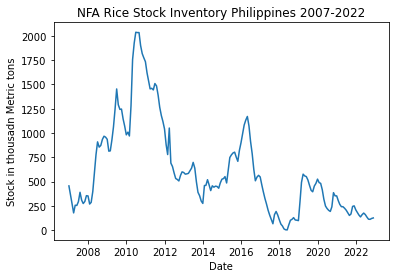

In [3]:
#Time Plot
#Plot the data for preliminary analysis
plt.title('NFA Rice Stock Inventory Philippines 2007-2022')
plt.xlabel("Date")
plt.ylabel("Stock in thousadn Metric tons")
plt.plot(RI)

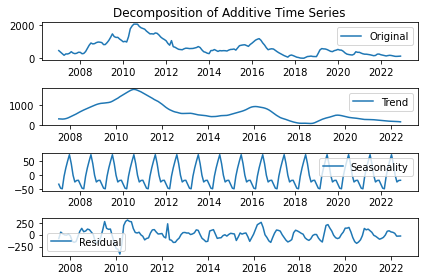

In [4]:
#Decompose the Time Plot
#Time Series Decomposition; Additive
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition=seasonal_decompose(RI["Rice Stock"],model="add")

trend=decomposition.trend
seasonal=decomposition.seasonal
residual=decomposition.resid

plt.subplot(411)
plt.title("Decomposition of Additive Time Series")
plt.plot(RI,label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend,label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual,label='Residual')
plt.legend(loc='best')
plt.tight_layout()

In [5]:
rice_stock=RI['Rice Stock']
values = rice_stock.values
training_data_len = 168

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))

train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [6]:
test_data = scaled_data[training_data_len-60: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [7]:
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 25)                2525      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


In [8]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs=3)

Epoch 1/3
108/108 [==============================] - 30s 53ms/step - loss: 0.0120
Epoch 2/3
108/108 [==============================] - 3s 31ms/step - loss: 0.0071
Epoch 3/3
108/108 [==============================] - 3s 31ms/step - loss: 0.0056


In [9]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

rmse = np.sqrt(np.mean(predictions - y_test)**2)
print('RMSE:',rmse)

1/1 [==============================] - 5s 5s/step
RMSE: 44.970636901855464


C:\Users\Gladys\AppData\Local\Temp\ipykernel_12744\3870184616.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


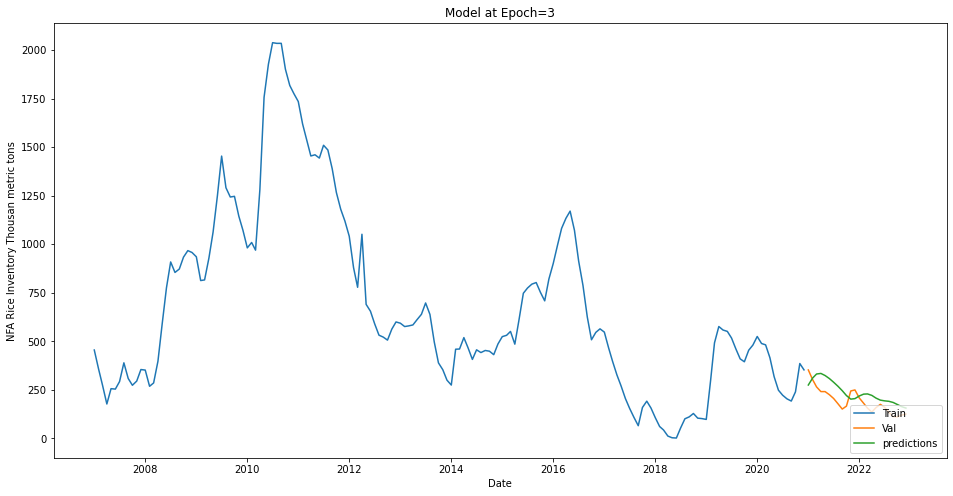

In [15]:
data = RI.filter(['Rice Stock'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model at Epoch=3')
plt.xlabel('Date')
plt.ylabel('NFA Rice Inventory Thousan metric tons')
plt.plot(train)
plt.plot(validation[['Rice Stock', 'Predictions']])
plt.legend(['Train', 'Val', 'predictions'], loc='lower right')
plt.show()

In [11]:
validation

,Rice Stock,Predictions
Date,,
2021-01-01,352.52,275.025299
2021-02-01,302.48,310.996857
2021-03-01,265.32,331.701752
2021-04-01,241.17,334.656525
2021-05-01,241.13,323.918671
2021-06-01,225.09,308.171692
2021-07-01,205.82,289.444855
2021-08-01,178.84,268.799957
2021-09-01,151.17,245.837097


In [12]:
Forecasted=validation['Predictions']
Forvalues=Forecasted.values
Forvalues

array([275.0253 , 310.99686, 331.70175, 334.65652, 323.91867, 308.1717 ,
       289.44485, 268.79996, 245.8371 , 220.84018, 202.34628, 204.93994,
       218.62263, 228.04768, 229.1342 , 221.54517, 207.53731, 197.18779,
       193.53209, 191.10289, 185.11711, 174.58553, 163.65512, 156.35866],
      dtype=float32)

In [13]:
Actual_test=validation['Rice Stock']
Actual_value=Actual_test.values
Actual_value

array([352.52, 302.48, 265.32, 241.17, 241.13, 225.09, 205.82, 178.84,
       151.17, 166.34, 244.32, 249.71, 208.33, 181.23, 155.87, 135.87,
       158.8 , 175.49, 160.5 , 134.61, 112.38, 111.04, 120.48, 125.3 ])

In [14]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

MAE = mean_absolute_error(Actual_value, Forvalues)
MAPE = mean_absolute_percentage_error(Actual_value, Forvalues)
RMSE = np.sqrt(mean_squared_error(Actual_value, Forvalues))

print(f'MAE - manual: {MAE}')
print(f'MAPE - manual: {MAPE}')
print(f'RMSE - manual: {RMSE}')

MAE - manual: 58.657176615397134
MAPE - manual: 0.3376111727676671
RMSE - manual: 63.919481496706176
